# price forcasting Notebook
This notebook loads data and prepares price prediction workflow.

In [34]:
import pandas as pd
import numpy as py

from google.colab import drive
drive.mount('/content/drive')

# Load CSV file from Google Drive
file_path = '/content/drive/MyDrive/fourth/project/wfp_food_prices_eth.csv'
df = pd.read_csv(file_path)

# Access a column
print(df.shape)
print(df.columns)

# View first 5 rows
print(df.head(8))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(40482, 14)
Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'commodity', 'unit', 'priceflag', 'pricetype', 'currency',
       'price', 'usdprice'],
      dtype='object')
         date       admin1                             admin2  \
0       #date   #adm1+name                         #adm2+name   
1  2000-01-15  Addis Ababa                           AA ZONE1   
2  2000-01-15  Addis Ababa                           AA ZONE1   
3  2000-01-15  Addis Ababa                           AA ZONE1   
4  2000-01-15  Addis Ababa                           AA ZONE1   
5  2000-01-15       Amhara  Administrative unit not available   
6  2000-01-15    Dire Dawa                          DIRE DAWA   
7  2000-01-15       Tigray                             MEKELE   

             market   latitude  longitude            category  \
0  #loc+m

In [35]:
import pandas as pd
import numpy as np

# Drop first row, reset index, convert date column to datetime, and cast numeric columns
df = (
    df.drop(0)
      .reset_index(drop=True)
      .assign(date=lambda x: pd.to_datetime(x['date']))
      .astype({'price': float, 'usdprice': float})
)

# Sort by date, drop duplicates, reset index
df = df.sort_values('date').drop_duplicates().reset_index(drop=True)

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Clean commodity column: remove parentheses text and extract variety
df['commodity_base'] = df['commodity'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()
df['variety'] = df['commodity'].str.extract(r'\((.*?)\)', expand=False).fillna('')

# Check missing values
print(df.isnull().sum())

# Replace unavailable admin2 values with NaN
df['admin2'] = df['admin2'].replace('Administrative unit not available', np.nan)

# Convert latitude and longitude to numeric
df[['latitude', 'longitude']] = df[['latitude', 'longitude']].apply(pd.to_numeric, errors='coerce')

# Keep only rows with positive price
df = df[df['price'] > 0].reset_index(drop=True)

# Convert categorical columns
df[['admin1', 'admin2', 'market', 'pricetype', 'category']] = df[['admin1', 'admin2', 'market', 'pricetype', 'category']].astype('category')

# Handle missing admin2 values
df['admin2'] = df['admin2'].cat.add_categories('Unknown').fillna('Unknown')

# Drop rows with missing admin1, latitude, longitude
df = df.dropna(subset=['admin1', 'latitude', 'longitude']).reset_index(drop=True)

# Replace empty variety with 'Standard'
df['variety'] = df['variety'].replace('', 'Standard').fillna('Standard')

# Clean unit column
df['unit'] = df['unit'].str.strip().str.upper()

# Drop unnecessary columns
df = df.drop(columns=['commodity','priceflag','currency'])

# Final checks
print(df.shape)
print(df.tail())
print(df.head())
print(df.info())

date              0
admin1            5
admin2            5
market            0
latitude          5
longitude         5
category          0
commodity         0
unit              0
priceflag         0
pricetype         0
currency          0
price             0
usdprice          0
year              0
month             0
commodity_base    0
variety           0
dtype: int64
(40476, 15)
            date   admin1  admin2             market  latitude  longitude  \
40471 2023-12-15  Gambela  ZONE 3  Kowerneng/Korgang  8.326659  33.953408   
40472 2023-12-15  Gambela  ZONE 2             Punido  7.749505  34.426848   
40473 2023-12-15  Gambela  ZONE 2             Punido  7.749505  34.426848   
40474 2023-12-15  Gambela  ZONE 2             Punido  7.749505  34.426848   
40475 2023-12-15   Somali    GODE               Gode  6.022500  43.130278   

                  category    unit pricetype    price  usdprice  year  month  \
40471   cereals and tubers  100 KG    Retail   4500.0   80.7609  2023   

✅ Preprocessing Complete
Shape: (39149, 38)

Data Types:
 date                              datetime64[ns]
admin1                                     int64
admin2                                     int64
market                                     int64
latitude                                 float64
longitude                                float64
unit                                       int64
pricetype                                  int64
price                                    float64
usdprice                                 float64
year                                       int32
month                                      int32
commodity_base                             int64
variety                                    int64
month_sin                                float64
month_cos                                float64
lag_1                                    float64
lag_3                                    float64
lag_6                                    float64
rolling_mea

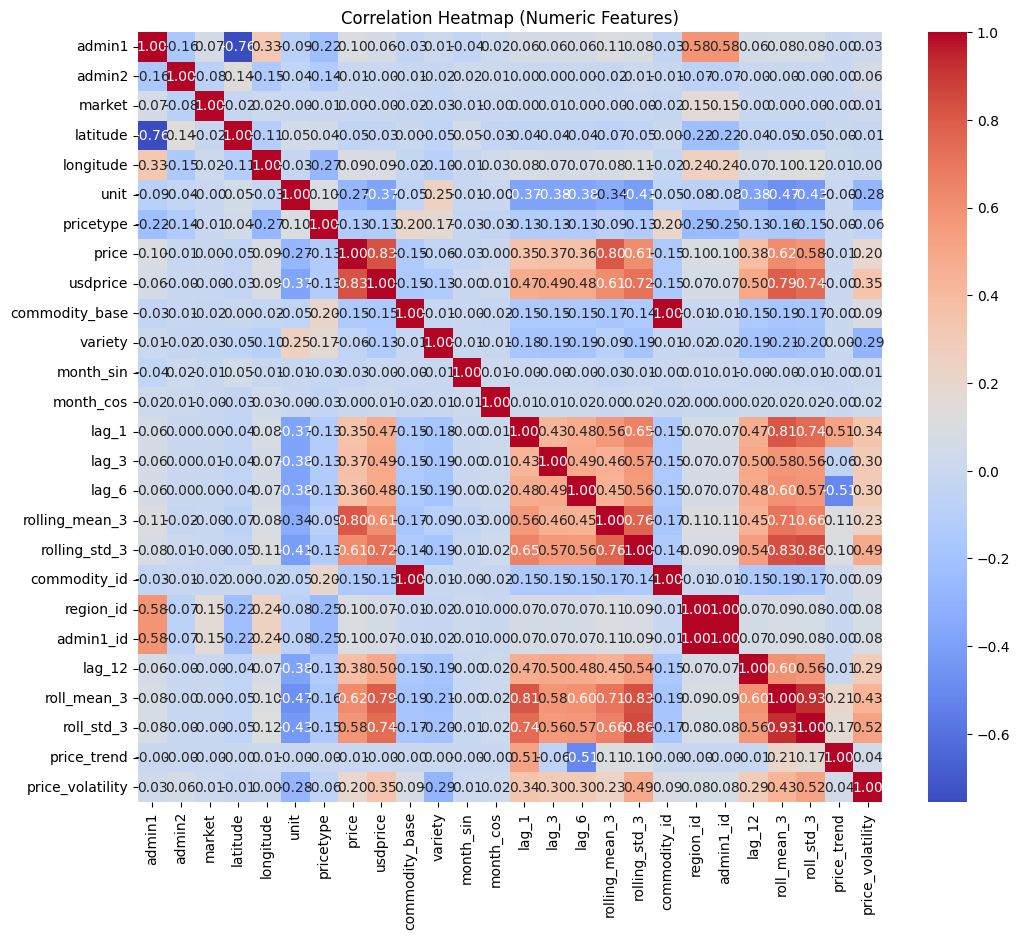

In [17]:
# ============================================================
# FULL DATA PREPROCESSING PIPELINE (ML READY)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1‴ CLEAN & STANDARDIZE UNITS
# -----------------------------
df['unit'] = df['unit'].astype(str).str.strip().str.upper()

# Convert bulk to per KG (optional but recommended)
df.loc[df['unit']=='100 KG','usdprice'] /= 100
df['unit'] = df['unit'].replace('100 KG','KG')

# -----------------------------
# 2‴ CLEAN & FIX PRICETYPE
# -----------------------------
df['pricetype'] = df['pricetype'].astype(str).str.strip().str.lower()

# Map to numeric safely using map (avoids FutureWarning)
pricetype_map = {'retail': 0, 'wholesale': 1, '0': 0, '1': 1}
df['pricetype'] = df['pricetype'].map(pricetype_map)

# Fill any remaining NaNs with mode
df['pricetype'] = df['pricetype'].fillna(df['pricetype'].mode()[0]).astype(int)

# -----------------------------
# 3‴ CLEAN & CONVERT OTHER CATEGORICALS
# -----------------------------
cat_cols = ['admin1','admin2','market'] # Removed 'category' from here
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip().replace('', 'Unknown').astype('category')

# -----------------------------
# 4‴ ONE-HOT ENCODING (LOW CARDINALITY)
# -----------------------------
if 'category' in df.columns:
    df = pd.get_dummies(df, columns=['category'], drop_first=True)

# Sanitize column names for LightGBM/XGBoost compatibility
df.columns = df.columns.str.replace(r'[^\w\s]+', '_', regex=True) # Replace special characters with underscore
df.columns = df.columns.str.replace(r'\s+', '_', regex=True) # Replace spaces with underscore
df.columns = df.columns.str.replace(r'__+', '_', regex=True) # Replace multiple underscores with single
df.columns = df.columns.str.strip('_') # Remove leading/trailing underscores

# -----------------------------
# 5‴ LABEL ENCODING (HIGH CARDINALITY)
# -----------------------------
label_cols = ['admin1','admin2','market','unit','commodity_base','variety']
encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# -----------------------------
# 6‴ FINAL CHECK
# -----------------------------
print("✅ Preprocessing Complete")
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nSample Data:")
print(df.head())

# -----------------------------
# 7‴ CORRELATION HEATMAP
# -----------------------------
numeric_df = df.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(12,10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40476 entries, 0 to 40475
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            40476 non-null  datetime64[ns]
 1   admin1                          40476 non-null  int64         
 2   admin2                          40476 non-null  int64         
 3   market                          40476 non-null  int64         
 4   latitude                        40476 non-null  float64       
 5   longitude                       40476 non-null  float64       
 6   unit                            40476 non-null  int64         
 7   pricetype                       40476 non-null  int64         
 8   price                           40476 non-null  float64       
 9   usdprice                        40476 non-null  float64       
 10  year                            40476 non-null  int32         
 11  mo

In [26]:
# ============================================================
# ADVANCED PRICE FORECASTING (LIGHTGBM FIXED & SAFE)
# Commodity + Region Forecast
# ============================================================

import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Optional Models
try:
    from xgboost import XGBRegressor
    xgb_available = True
except:
    xgb_available = False

try:
    from lightgbm import LGBMRegressor
    lgbm_available = True
except:
    lgbm_available = False


# ============================================================
# 1️⃣ SORT DATA
# ============================================================
df = df.sort_values('date')

# ============================================================
# 2️⃣ CLEAN COLUMN NAMES (IMPORTANT FOR LIGHTGBM)
# ============================================================
df.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in df.columns]

# ============================================================
# 3️⃣ ENCODE CATEGORICAL & OBJECT COLUMNS
# ============================================================
cat_cols = [
    'admin1','admin2','market',
    'commodity_base','variety','unit','pricetype'
]

encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

# ============================================================
# 4️⃣ TIME FEATURES
# ============================================================
df['month_sin'] = np.sin(2*np.pi*df['month']/12)
df['month_cos'] = np.cos(2*np.pi*df['month']/12)
df['year_trend'] = df['year'] - df['year'].min()
df['quarter'] = df['date'].dt.quarter

# ============================================================
# 5️⃣ LAG FEATURES (Commodity + Region)
# ============================================================
group_cols = ['commodity_base','admin1']

df['lag_1']  = df.groupby(group_cols)['usdprice'].shift(1)
df['lag_3']  = df.groupby(group_cols)['usdprice'].shift(3)
df['lag_6']  = df.groupby(group_cols)['usdprice'].shift(6)
df['lag_12'] = df.groupby(group_cols)['usdprice'].shift(12)

df['roll_mean_3'] = df.groupby(group_cols)['usdprice']\
                        .transform(lambda x: x.rolling(3).mean())

df['roll_std_3'] = df.groupby(group_cols)['usdprice']\
                        .transform(lambda x: x.rolling(3).std())

df['price_trend'] = df['lag_1'] - df['lag_6']
df['price_volatility'] = df['roll_std_3'] / df['roll_mean_3']

# ============================================================
# 6️⃣ REMOVE NA FROM LAGS
# ============================================================
df_model = df.dropna().reset_index(drop=True)

# ============================================================
# 7️⃣ FEATURES & TARGET
# ============================================================
features = [
    'admin1','admin2','market',
    'latitude','longitude',
    'commodity_base','variety','unit','pricetype',
    'month_sin','month_cos','quarter','year_trend',
    'lag_1','lag_3','lag_6','lag_12',
    'roll_mean_3','roll_std_3','price_trend','price_volatility'
]

# include one-hot nutrition categories if exist
features += [c for c in df_model.columns if c.startswith('category_')]

X = df_model[features]
y = df_model['usdprice']

# ============================================================
# 8️⃣ CLEAN FEATURE NAMES AGAIN (FINAL SAFETY)
# ============================================================
X.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in X.columns]

# ============================================================
# 9️⃣ TIME SERIES SPLIT
# ============================================================
split = int(len(df_model)*0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ============================================================
# 🔟 MODELS
# ============================================================
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor()
}

if xgb_available:
    models["XGBoost"] = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

if lgbm_available:
    models["LightGBM"] = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# ============================================================
# 1️⃣1️⃣ TRAIN & EVALUATE
# ============================================================
results = {}
all_preds = {} # Dictionary to store predictions for all models

for name, model in models.items():

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    all_preds[name] = preds # Store predictions here

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    results[name] = mae

    print(f"\n{name}")
    print("MAE :", round(mae,2))
    print("RMSE:", round(rmse,2))

# ============================================================
# 1️⃣2️⃣ BEST MODEL
# ============================================================
best_name = min(results, key=results.get)
best_model = models[best_name]

print("\n🏆 BEST MODEL:", best_name)

# ============================================================
# 1️⃣3️⃣ FEATURE IMPORTANCE
# ============================================================
if hasattr(best_model, "feature_importances_"):
    importance = pd.Series(best_model.feature_importances_, index=X.columns)
    print("\n🔝 Most Important Features:")
    print(importance.sort_values(ascending=False).head(10))

# ============================================================
# 1️⃣4️⃣ NEXT PERIOD FORECAST
# ============================================================
future_price = best_model.predict(X_test.tail(1))[0]
print("\n📈 Next predicted price:", round(future_price,2))


Linear Regression
MAE : 28.62
RMSE: 70.99

Random Forest
MAE : 12.26
RMSE: 36.59

Gradient Boosting
MAE : 16.27
RMSE: 41.09

XGBoost
MAE : 13.51
RMSE: 40.83
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2589
[LightGBM] [Info] Number of data points in the train set: 30389, number of used features: 21
[LightGBM] [Info] Start training from score 53.179911

LightGBM
MAE : 13.68
RMSE: 39.59

🏆 BEST MODEL: Random Forest

🔝 Most Important Features:
roll_mean_3         0.560090
variety             0.262990
roll_std_3          0.089905
price_volatility    0.031749
lag_1               0.013508
latitude            0.008193
unit                0.006772
price_trend         0.005239
lag_3               0.003261
pricetype           0.003250
dtype: float64

📈 Next predicted price: 8.16


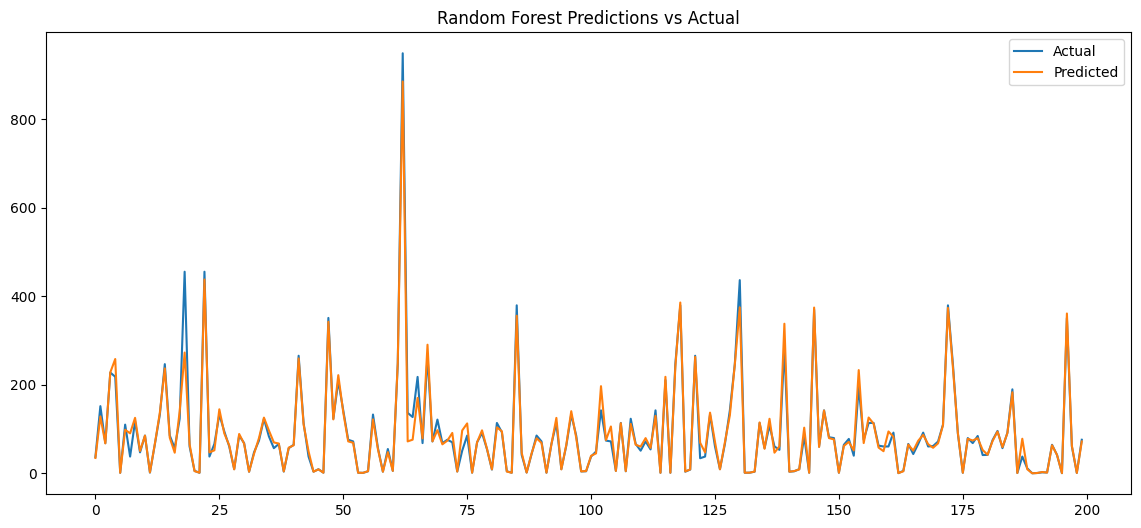

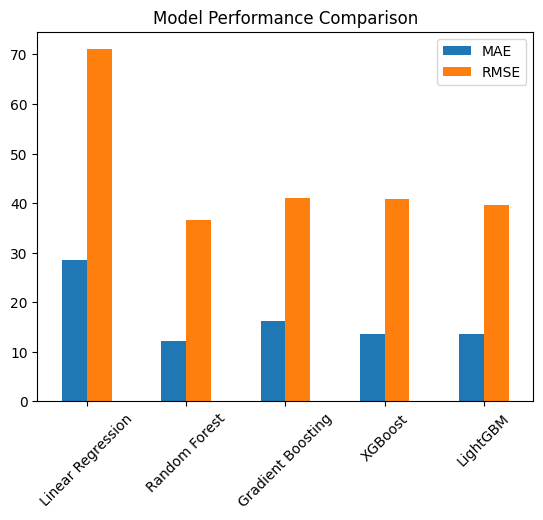

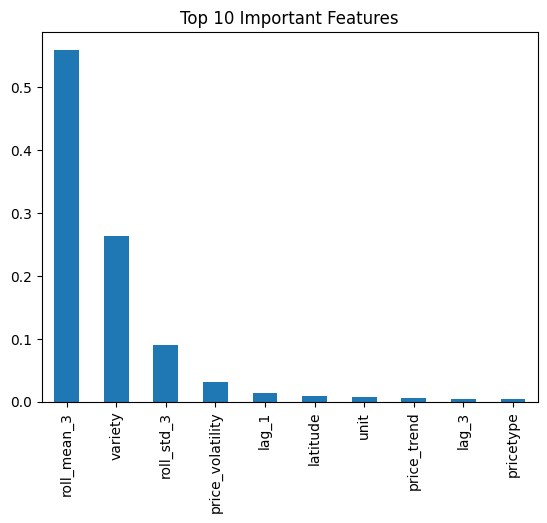

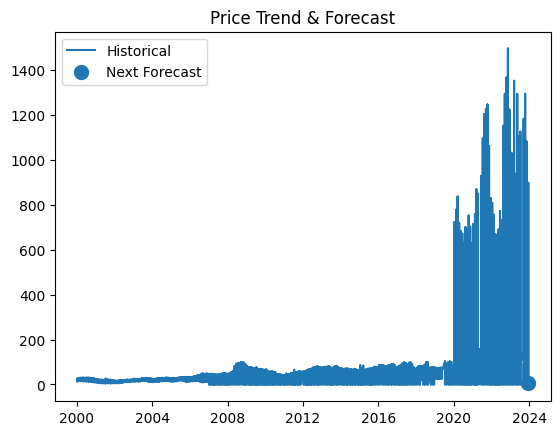

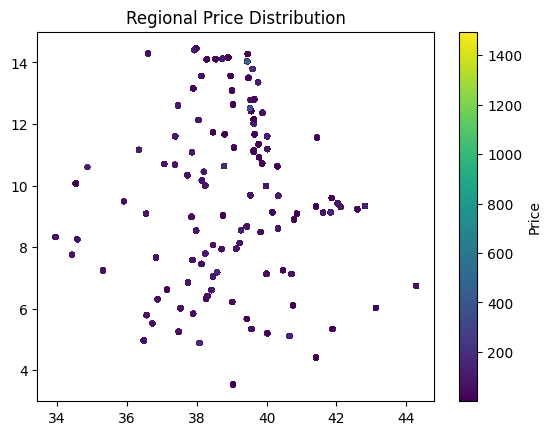

📊 Visualization Complete


In [32]:
# ============================================================
# FORECAST VISUALIZATION DASHBOARD
# ============================================================

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error # Added imports for robustness
import numpy as np # Import numpy for sqrt

# ===============================
# 1️⃣ ACTUAL vs PREDICTED
# ===============================
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:200], label='Actual')
plt.plot(all_preds[best_name][:200], label='Predicted') # Changed to use all_preds and best_name
plt.title(f"{best_name} Predictions vs Actual") # Changed to use best_name
plt.legend()
plt.show()

# ===============================
# 2️⃣ MODEL PERFORMANCE COMPARISON
# ===============================
mae_scores = {name: mean_absolute_error(y_test, all_preds[name]) for name in all_preds} # Changed to use all_preds
rmse_scores = {name: np.sqrt(mean_squared_error(y_test, all_preds[name])) for name in all_preds} # Fixed: removed squared=False

perf_df = pd.DataFrame({
    'MAE': mae_scores,
    'RMSE': rmse_scores
})

perf_df.plot(kind='bar')
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.show()

# ===============================
# 3️⃣ FEATURE IMPORTANCE (BEST MODEL)
# ===============================
# The 'importance' variable is already calculated and available from the previous cell
if hasattr(best_model, "feature_importances_"):
    importance.nlargest(10).plot(kind='bar')
    plt.title("Top 10 Important Features")
    plt.show()

# ===============================
# 4️⃣ PRICE TREND + FORECAST
# ===============================
plt.figure()
plt.plot(df['date'], df['usdprice'], label='Historical')
plt.scatter(df['date'].iloc[-1], future_price, label='Next Forecast', s=100) # Changed next_price to future_price
plt.title("Price Trend & Forecast")
plt.legend()
plt.show()

# ===============================
# 5️⃣ REGIONAL PRICE DISTRIBUTION
# ===============================
plt.figure()
plt.scatter(df['longitude'], df['latitude'], c=df['usdprice'], s=10)
plt.title("Regional Price Distribution")
plt.colorbar(label='Price')
plt.show()

print("📊 Visualization Complete")


Linear Regression
MAE : 26.02
RMSE: 71.11

Random Forest
MAE : 11.75
RMSE: 32.55

Gradient Boosting
MAE : 15.62
RMSE: 37.34

XGBoost
MAE : 12.11
RMSE: 35.21
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2589
[LightGBM] [Info] Number of data points in the train set: 30389, number of used features: 21
[LightGBM] [Info] Start training from score 53.237223

LightGBM
MAE : 12.75
RMSE: 36.49

🏆 BEST MODEL: Random Forest

🔝 Top Features:
roll_mean_3         0.560884
variety             0.236950
roll_std_3          0.114846
unit                0.030643
price_volatility    0.016568
lag_1               0.016285
pricetype           0.003405
price_trend         0.002825
lag_3               0.002810
latitude            0.002758
dtype: float64

📈 Next predicted price: 8.55


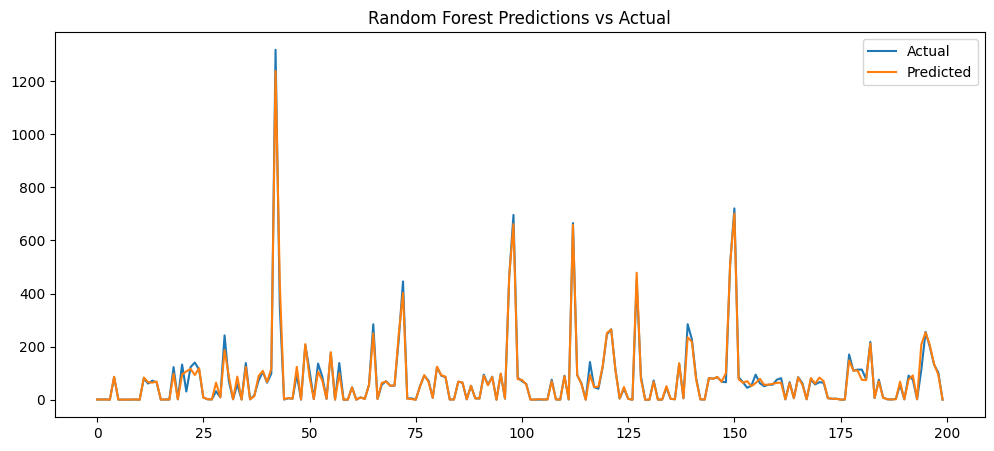

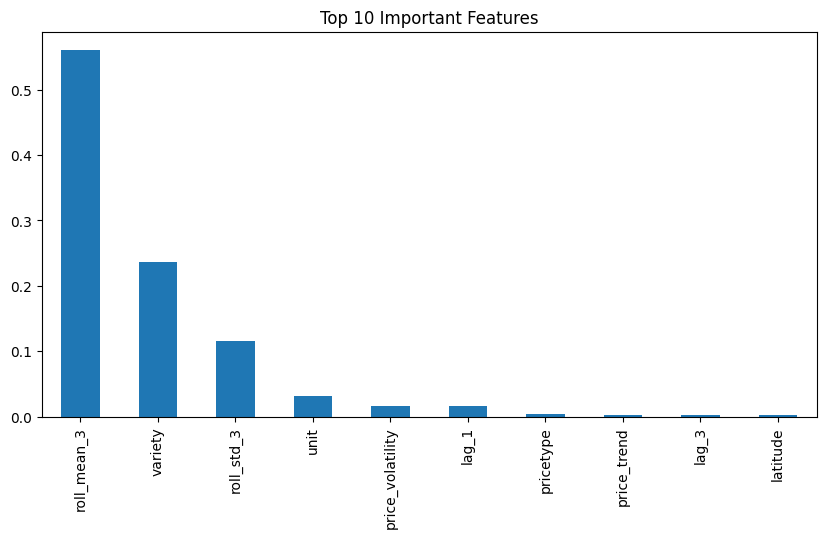

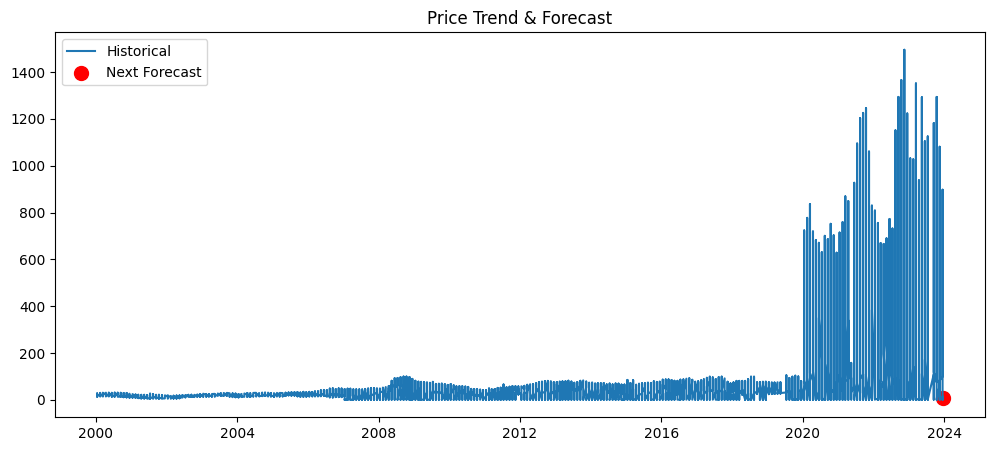

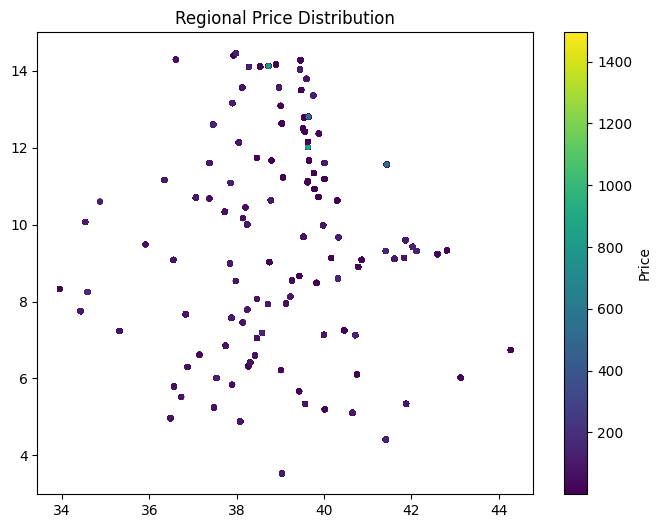

📊 Visualization Complete


In [36]:
# ============================================================
# ADVANCED PRICE FORECASTING (LIGHTGBM SAFE + TIME SPLIT)
# Commodity + Region Forecast
# ============================================================

import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Optional Models
try:
    from xgboost import XGBRegressor
    xgb_available = True
except:
    xgb_available = False

try:
    from lightgbm import LGBMRegressor
    lgbm_available = True
except:
    lgbm_available = False

# ============================================================
# 1️⃣ SORT DATA BY DATE
# ============================================================
df = df.sort_values('date')

# ============================================================
# 2️⃣ CLEAN COLUMN NAMES (SAFE FOR LIGHTGBM)
# ============================================================
df.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in df.columns]

# ============================================================
# 3️⃣ ENCODE CATEGORICAL / OBJECT COLUMNS
# ============================================================
cat_cols = ['admin1','admin2','market','commodity_base','variety','unit','pricetype']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

# ============================================================
# 4️⃣ TIME FEATURES
# ============================================================
df['month_sin'] = np.sin(2*np.pi*df['month']/12)
df['month_cos'] = np.cos(2*np.pi*df['month']/12)
df['year_trend'] = df['year'] - df['year'].min()
df['quarter'] = df['date'].dt.quarter

# ============================================================
# 5️⃣ LAG FEATURES (Commodity + Region)
# ============================================================
group_cols = ['commodity_base','admin1']

df['lag_1']  = df.groupby(group_cols)['usdprice'].shift(1)
df['lag_3']  = df.groupby(group_cols)['usdprice'].shift(3)
df['lag_6']  = df.groupby(group_cols)['usdprice'].shift(6)
df['lag_12'] = df.groupby(group_cols)['usdprice'].shift(12)

df['roll_mean_3'] = df.groupby(group_cols)['usdprice'].transform(lambda x: x.rolling(3).mean())
df['roll_std_3'] = df.groupby(group_cols)['usdprice'].transform(lambda x: x.rolling(3).std())

df['price_trend'] = df['lag_1'] - df['lag_6']
df['price_volatility'] = df['roll_std_3'] / df['roll_mean_3']

# ============================================================
# 6️⃣ REMOVE NA FROM LAGS
# ============================================================
df_model = df.dropna().reset_index(drop=True)

# ============================================================
# 7️⃣ FEATURES & TARGET
# ============================================================
features = [
    'admin1','admin2','market',
    'latitude','longitude',
    'commodity_base','variety','unit','pricetype',
    'month_sin','month_cos','quarter','year_trend',
    'lag_1','lag_3','lag_6','lag_12',
    'roll_mean_3','roll_std_3','price_trend','price_volatility'
]

# Include any nutrition/other one-hot columns
features += [c for c in df_model.columns if c.startswith('category_')]

X = df_model[features]
y = df_model['usdprice']

# ============================================================
# 8️⃣ CLEAN FEATURE NAMES AGAIN (SAFE)
# ============================================================
X.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in X.columns]

# ============================================================
# 9️⃣ TIME-BASED SPLIT (80% train, 20% test)
# ============================================================
split_index = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# ============================================================
# 🔟 MODELS
# ============================================================
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor()
}

if xgb_available:
    models["XGBoost"] = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

if lgbm_available:
    models["LightGBM"] = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# ============================================================
# 1️⃣1️⃣ TRAIN & EVALUATE
# ============================================================
results = {}
all_preds = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    all_preds[name] = preds

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results[name] = mae

    print(f"\n{name}")
    print("MAE :", round(mae, 2))
    print("RMSE:", round(rmse, 2))

# ============================================================
# 1️⃣2️⃣ BEST MODEL
# ============================================================
best_name = min(results, key=results.get)
best_model = models[best_name]

print("\n🏆 BEST MODEL:", best_name)

# ============================================================
# 1️⃣3️⃣ FEATURE IMPORTANCE (if available)
# ============================================================
if hasattr(best_model, "feature_importances_"):
    importance = pd.Series(best_model.feature_importances_, index=X.columns)
    print("\n🔝 Top Features:")
    print(importance.sort_values(ascending=False).head(10))

# ============================================================
# 1️⃣4️⃣ NEXT PERIOD FORECAST
# ============================================================
future_price = best_model.predict(X_test.tail(1))[0]
print("\n📈 Next predicted price:", round(future_price,2))

# ============================================================
# 1️⃣5️⃣ VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt

# Actual vs Predicted (first 200 points)
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label='Actual')
plt.plot(all_preds[best_name][:200], label='Predicted')
plt.title(f"{best_name} Predictions vs Actual")
plt.legend()
plt.show()

# Feature Importance Plot (if exists)
if hasattr(best_model, "feature_importances_"):
    importance.nlargest(10).plot(kind='bar', figsize=(10,5))
    plt.title("Top 10 Important Features")
    plt.show()

# Price Trend + Next Forecast
plt.figure(figsize=(12,5))
plt.plot(df['date'], df['usdprice'], label='Historical')
plt.scatter(df['date'].iloc[-1], future_price, color='red', label='Next Forecast', s=100)
plt.title("Price Trend & Forecast")
plt.legend()
plt.show()

print("📊 Visualization Complete")